Post-suite2P data preprocessing for communication subspace analysis

To use the Semedo et al. code for reduced rank regression etc., the output should be an nxm matrix, where n=number of cells and m = (n trials x n samples in trial bin). If you save this as a .npy, it can be imported to MATLAB using the readNPY.m function found in [npy-matlab](https://github.com/kwikteam/npy-matlab) package.

0.7 neuropil subtraction applied: this can be changed in utils_funcs.s2p_loader

In [1]:
#ipython magic
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [24]:
# general imports
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [3]:
# global plotting params
sns.set()
sns.set_style('white')
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         'axes.linewidth' : 3,
         'font.family' : 'sans-serif',
         'font.weight' : 'regular'}
plt.rc("axes.spines", top=False, right=False) # despine
plt.rcParams.update(params)

In [76]:
#notebook specific imports
import utils.utils_funcs as utils
# from utils.utils_funcs import *
from utils.paq2py import paq_read
import sfuncs

In [19]:
s2p_path = '/Volumes/PackerStation/'\
           'sarmstrong/Data/2019-07-24/2019-07-24_RL042_t-002/suite2p' #this is an example file 

In [20]:
paq_path = '/Volumes/PackerStation/'\
           'sarmstrong/Data/2019-07-24/2019-07-24_RL042_B2_2P_t002.paq'

In [54]:
# process 1 plane at a time for now
plane = 1 # select plane to process. This is zero-indexed!
tot_planes = 2 # how many planes did you record in total?
fs = 1/0.043478004 # total frame rate Hz (1/frame period from xml file accompanying your recording. This will change when using custom ROIs)
fs = fs / tot_planes #total frame rate is divided by number of planes
print('plane recorded at {0:.4f} frames per second'.format(fs))

plane recorded at 11.5001 frames per second


In [33]:
#if there's an error here, make sure you're connected to PackerStation
raw, spks, stat = utils.s2p_loader(os.path.join(s2p_path, 'plane{}'.format(plane)))
raw.shape

Loading 342 traces labelled as cells
Subtracting neuropil with a coefficient of 0.7


(342, 12881)

In [34]:
dff = dfof2(raw) #compute dF/F
dff.shape

(342, 12881)

## Split cells into S1 and S2

In [60]:
#in suite2p, find the cell that is furthest to the right in area S1 and note its index. We will split the cells by a linear plane through the cell's X-coordinate
c = getKeyFromStat_1plane(stat,'med',conditional=('original_index',19)) 
print('X coordinate at S1S2 boundary = {}'.format(c[0][1]))

Retrieving values for med key where condition met: original_index == 19
X coordinate at S1S2 boundary = 458.0


In [61]:
#split cells by boundary coordinate
S1_indices, S2_indices = separateByX(stat,boundary) #split all cells in stat based on X coordinate
print('number S1 cells =',len(S1_indices),'; number S2 cells =',len(S2_indices))

number S1 cells = 185 ; number S2 cells = 157


In [62]:
#check the split has been performed correctly
print(len(S2_indices) + len (S1_indices) == stat.shape[0]) # should be True

#check there are no cells in the same group (output should be empty)
set(S1_indices) & set(S2_indices) 

True


set()

In [63]:
S1_stat = stat[S1_indices]
S2_stat = stat[S2_indices]

In [64]:
#get deconvolved spikes and dF/F for each area
S1_spks = spks[S1_indices]
S2_spks = spks[S2_indices]
S1_dff = dff[S1_indices]
S2_dff = dff[S2_indices]
print(S1_dff.shape, S2_dff.shape) #shape[0] should == len(Sx_indices)

(185, 12881) (157, 12881)


In [65]:
tot_frames = dff.shape[1] * tot_planes
tot_frames

25762

In [68]:
paq = paq_read(paq_path)
paq['chan_names']

['frame_clock', 'camera_frame', 'piezo_stim']

In [69]:
stim_start = utils.paq_data(paq, 'piezo_stim', threshold_ttl = True)
len(stim_start)

100

In [80]:
# get piezo stimulus timings 
stim_start_frames = sfuncs.stim_start_frame(paq,'piezo_stim')

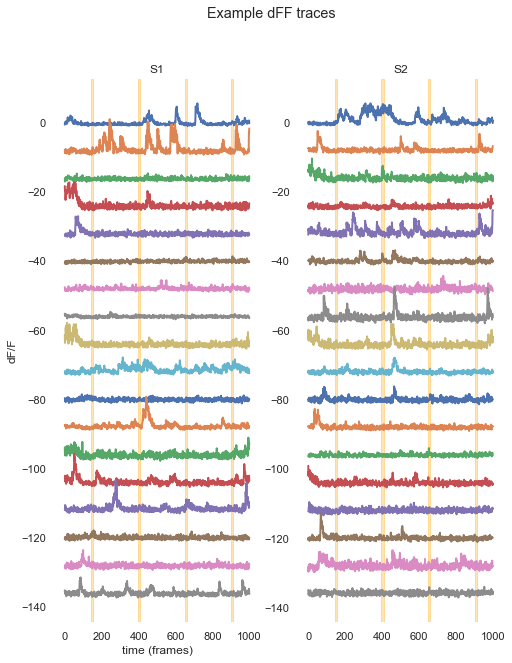

In [84]:
#plot example traces: dFF whole trace with stim timings in orange
stim_duration_f = fs*1
fig = plt.figure(figsize=(8,10))
ax1=fig.add_subplot(121)
plt.ylabel('dF/F')
plt.xlabel('time (frames)')
plt.title('S1')
ax2=fig.add_subplot(122)
plt.title('S2')
for i,unit in enumerate(S1_dff[5:23]):
    line_offset = i*8
    ax1.plot(unit[0:1000]-line_offset,linewidth=2)
for i,unit in enumerate(S2_dff[2:20]):
    line_offset = i*8
    ax2.plot(unit[0:1000]-line_offset,linewidth=2)
for t in stim_start_frames[0:4]:
    ax1.axvspan(xmin=t,xmax=t+stim_duration_f,color='orange',alpha=0.3,zorder=0)
    ax2.axvspan(xmin=t,xmax=t+stim_duration_f,color='orange',alpha=0.3,zorder=0)
sns.despine(left=1,bottom=1)
plt.suptitle('Example dFF traces')
plt.show()

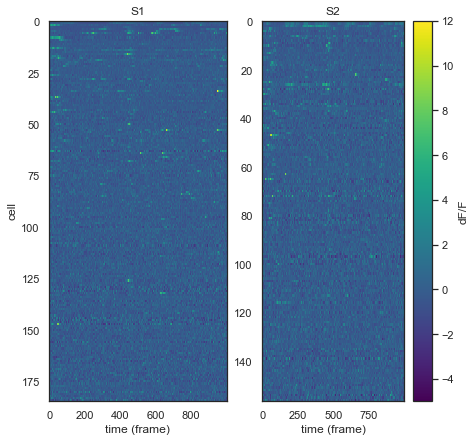

In [86]:
#visualise as heatmap
fig = plt.figure(figsize=(7,7))
cmap = plt.get_cmap('viridis')
ax1=fig.add_subplot(121)
plt.title('S1')
ax2=fig.add_subplot(122)
plt.title('S2')
img = ax1.imshow(S1_dff[:,0:1000],aspect='auto',cmap=cmap,vmin=-5,vmax=12)
img2 = ax2.imshow(S2_dff[:,0:1000],aspect='auto',cmap=cmap,vmin=-5,vmax=12)
ax1.set_ylabel('cell')
for ax in fig.axes:
    ax.set_xlabel('time (frame)')
plt.colorbar(img2,label='dF/F')
plt.show()

In [87]:
frame_clock = utils.paq_data(paq, 'frame_clock', threshold_ttl = True)
frame_clock = frame_clock[:tot_frames] # get rid of foxy bonus frames
frame_clock = frame_clock[plane::tot_planes] # just take clocks from the frame you care about

In [90]:
# set the time window for each trial bin here. The authors of the Semedo paper take 1 second of data 
# per trial. As our stim is longer i'll try taking 2 seconds post-stimulus onset. 
# Worth playing with this

pre_seconds = 0
post_seconds = 2
pre_frames = int(pre_seconds * fs) # number of frames before stim onset to inlcude in the trial
post_frames = int(post_seconds * fs) # number of frames after stim onset to inlcude in the trial

offset_s = 0 # option to offset trial bins from stimulus onset
second_in_samples = 22000
offset_frames = int(offset_s * second_in_samples)

In [109]:
#spikes S1
spks_trials_S1 = utils.flu_splitter(S1_spks, frame_clock, stim_start, pre_frames, post_frames)
spks_trials_S1 = spks_trials_S1[0]
spks_trials_S1.shape

(185, 23, 100)

In [110]:
#spikes S2
spks_trials_S2 = utils.flu_splitter(S2_spks, frame_clock, stim_start, pre_frames, post_frames)
spks_trials_S2 = spks_trials_S2[0]
spks_trials_S2.shape

(157, 23, 100)

In [111]:
#dFF S1
dff_trials_S1 = utils.flu_splitter(S1_dff, frame_clock, stim_start+offset_frames, pre_frames, post_frames)
dff_trials_S1 = dff_trials_S1[0]
dff_trials_S1.shape

(185, 23, 100)

In [112]:
#dFF S2
dff_trials_S2 = utils.flu_splitter(S2_dff, frame_clock, stim_start+offset_frames, pre_frames, post_frames)
dff_trials_S2 = dff_trials_S2[0]
dff_trials_S2.shape

(157, 23, 100)

## Choose which data to process here

In [113]:
data = dff_trials_S1 #which s1 data to use. dff_trials, spks_trials
dataS2 = dff_trials_S2 

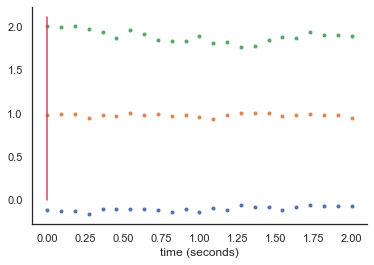

In [117]:
#visualise example data
axes = plt.gca()
x_axis = np.linspace(-pre_seconds, post_seconds, data.shape[1]) 
for i in range(3):
    meaned = np.mean(data[i,:,:],1) + i
    plt.plot(x_axis, meaned, '.')
plt.plot(np.zeros(10), np.linspace(0, axes.get_ylim()[1],10))
plt.xlabel('time (seconds)')
sns.despine()
plt.show()

In [118]:
# trial average each cell
mean_trial = np.mean(data, 2)
mean_trial_S2 = np.mean(dataS2, 2)

# reshape for subtraction
mean_trial = mean_trial.reshape(data.shape[0], data.shape[1], 1) 
mean_trial_S2 = mean_trial_S2.reshape(dataS2.shape[0], dataS2.shape[1], 1) 

#check shapes are as expected
print('S1 shape:',mean_trial.shape)
print('S2 shape:',mean_trial_S2.shape)

S1 shape: (185, 23, 1)
S2 shape: (157, 23, 1)


In [119]:
# subtract trial average from each trial
S1_subbed = data - mean_trial #subtract mean from spikes 
assert S1_subbed.shape == data.shape

S2_subbed = dataS2 - mean_trial_S2 #subtract mean from spikes 
assert S2_subbed.shape == dataS2.shape

In [120]:
# data = mean spikes in x ms
S2_subbed.shape

(157, 23, 100)

In [121]:
S1_subbed = S1_subbed.reshape(S1_subbed.shape[0],S1_subbed.shape[1]*S1_subbed.shape[2])
S2_subbed = S2_subbed.reshape(S2_subbed.shape[0],S2_subbed.shape[1]*S2_subbed.shape[2])

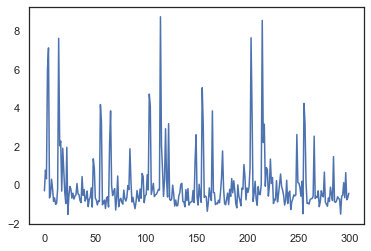

In [127]:
plt.plot(S1_subbed[6,0:300])
plt.show()

In [128]:
trial_dur = pre_frames + post_frames

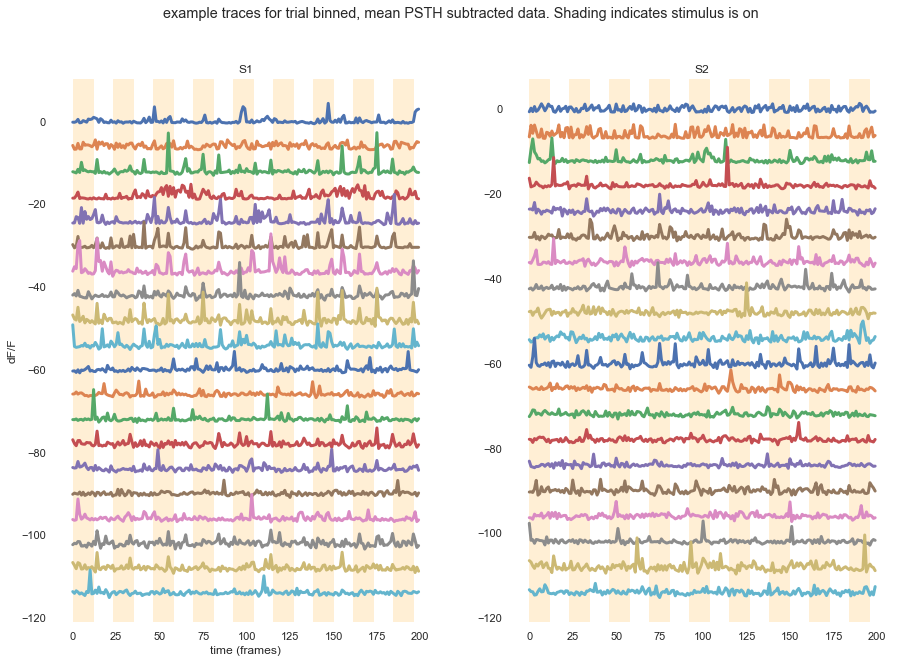

17.39 seconds of trace plotted, which contains 9 trials


In [134]:
#plot example traces: dff in trial bins
plottime = (0,200) #time to plot
n_traces = 20 #how many example cells to plot traces from
lw = 3 #linewidth
ls = 6 #spacing between traces

stim_duration_f = fs*1
fig = plt.figure(figsize=(15,10))
ax1=fig.add_subplot(121)
plt.ylabel('dF/F')
plt.xlabel('time (frames)')
plt.title('S1')
ax2=fig.add_subplot(122)
plt.title('S2')
for i,unit in enumerate(S1_subbed[0:n_traces]):
    line_offset = i*ls
    ax1.plot(unit[plottime[0]:plottime[1]]-line_offset,linewidth=lw)
for i,unit in enumerate(S2_subbed[0:n_traces]):
    line_offset = i*ls
    ax2.plot(unit[plottime[0]:plottime[1]]-line_offset,linewidth=lw)
for t in np.arange(0,(plottime[1]-plottime[0]),trial_dur):
    ax1.axvspan(xmin=t+pre_frames,xmax=t+pre_frames+stim_duration_f,color='papayawhip',zorder=0)
    ax2.axvspan(xmin=t+pre_frames,xmax=t+pre_frames+stim_duration_f,color='papayawhip',zorder=0)
sns.despine(left=1,bottom=1)
plt.suptitle('example traces for trial binned, mean PSTH subtracted data. Shading indicates stimulus is on')
plt.show()
print(round((plottime[1]-plottime[0])/fs,2),'seconds of trace plotted, which contains',len(np.arange(0,(plottime[1]-plottime[0]),trial_dur)),'trials')

In [135]:
#Shuffle the data

In [140]:
S1_dff_shuffled = np.random.permutation(S1_subbed.T).T

In [141]:
S2_dff_shuffled = np.random.permutation(S2_subbed.T).T

In [142]:
#check the first 3 values are not the same
print(S2_dff_shuffled[0,0:3],S2_subbed[0,0:3])
print(S1_dff_shuffled[0,0:3],S1_subbed[0,0:3])

[1.4560288  0.28286397 0.87012756] [-0.67541885  0.18099988 -0.64371383]
[-0.26357925 -0.38165596  0.93816715] [-0.28635716 -0.30697572 -0.15694518]


In [143]:
#check that this has shuffled the datapoints within each recording, not shuffled the rows around. Should be True
S1_dff_shuffled[0] in S1_subbed[0]

True

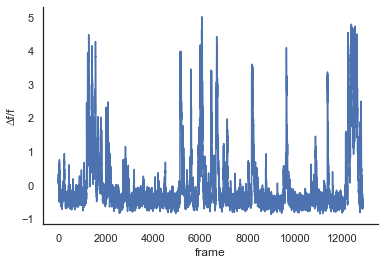

In [144]:
plt.plot(S1_dff[0])
plt.xlabel('frame')
plt.ylabel('∆f/f')
sns.despine()
plt.show()

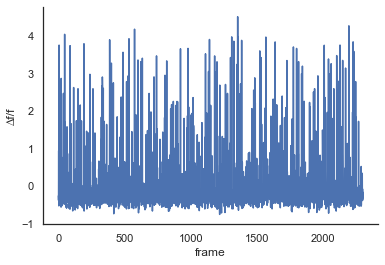

In [145]:
plt.plot(S1_dff_shuffled[0])
plt.xlabel('frame')
plt.ylabel('∆f/f')
sns.despine()
plt.show()

In [ ]:
#np.save(......)